**This ipynb contains process of data exploration and visualization that helps us make inference on deciding which of the 2 ridesharing company is better for the consumer.**

Time frame of data: 26th Nov 2018 to 19th Dec 2018 (24 days)

Location: Boston, MA

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [5]:
GLstats = pd.read_csv('cab_rides.csv')

<b> Rain Impact with linear regression, random forest, gradient boosting, and KNN </b>


Performing rain impact analysis for Lyft...



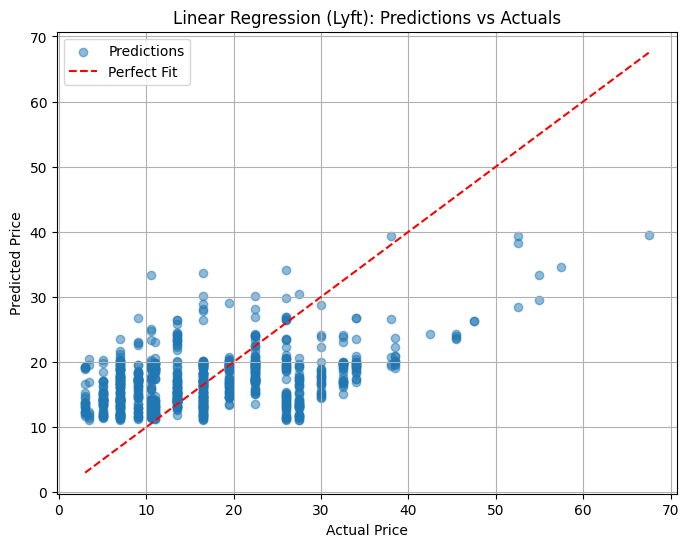

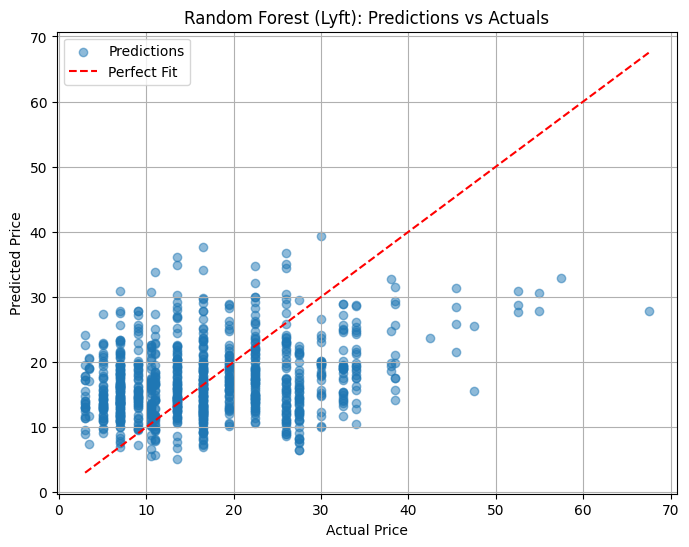

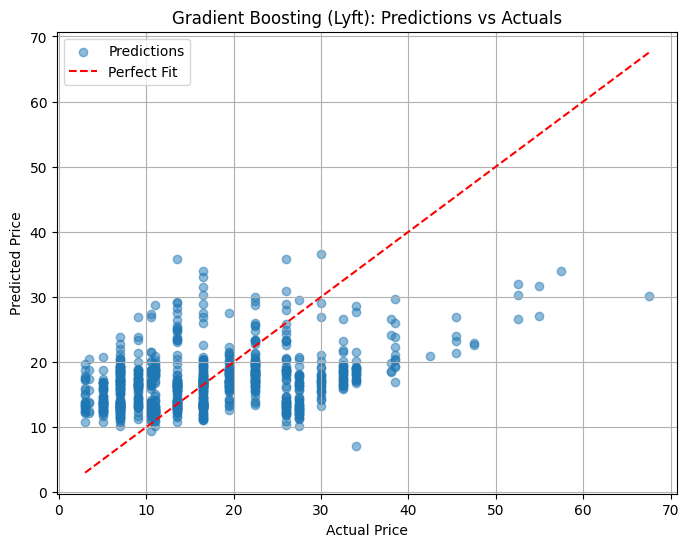

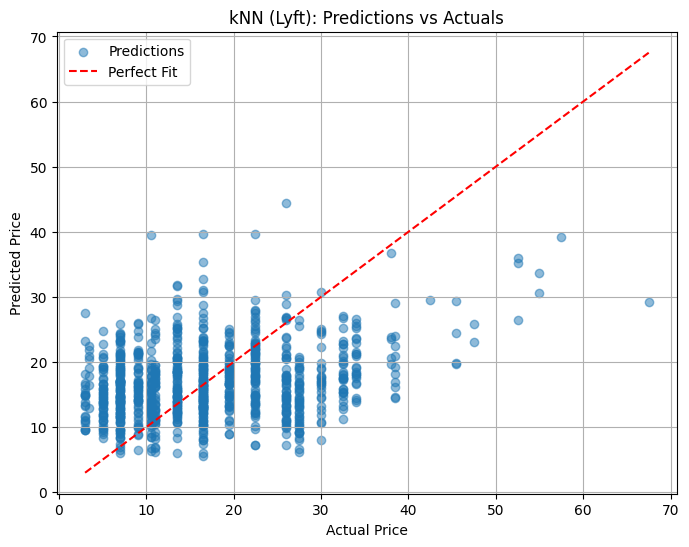


Performance Metrics for Lyft:

                         MSE        R2
Linear Regression  77.235512  0.193262
Random Forest      95.314737  0.004422
Gradient Boosting  83.012457  0.132921
kNN                94.840404  0.009376

Performing rain impact analysis for Uber...



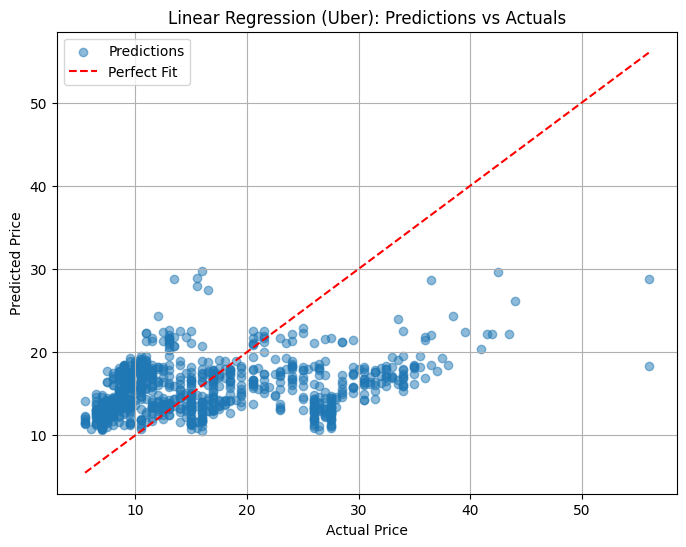

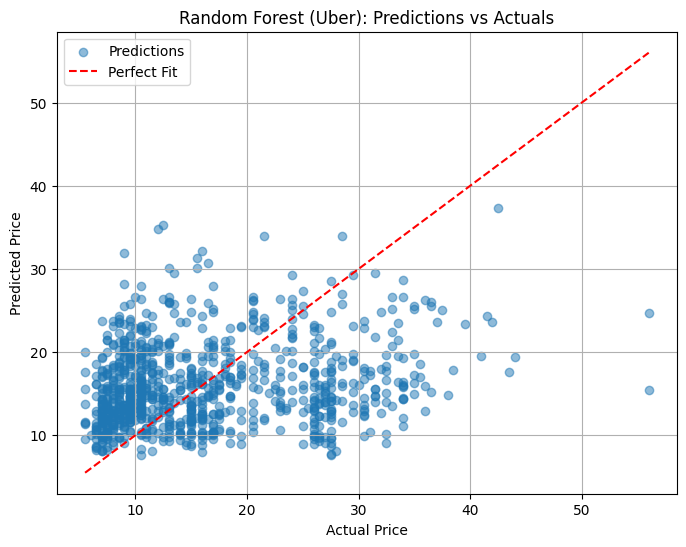

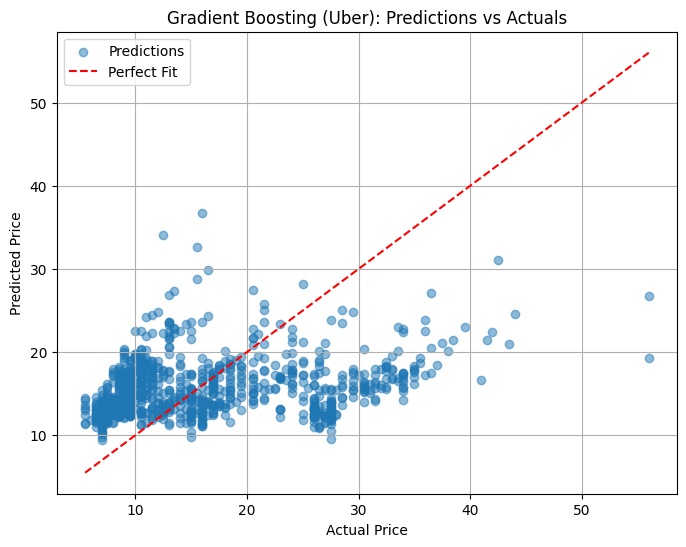

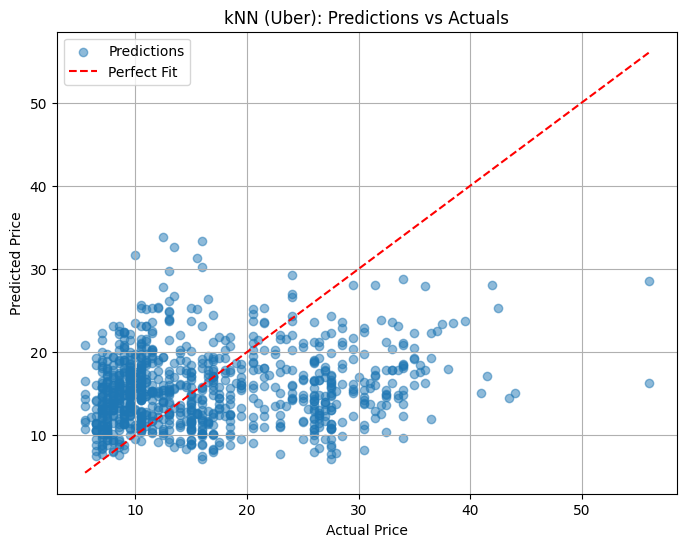


Performance Metrics for Uber:

                         MSE        R2
Linear Regression  67.919604  0.090813
Random Forest      81.267886  -0.08787
Gradient Boosting  71.249085  0.046244
kNN                81.140924  -0.08617


In [17]:
# Updated feature set to include impactful variables
features = [
    'precipIntensity', 'temperature', 'humidity', 'windSpeed', 'visibility',
    'distance', 'surge_multiplier', 'hour'
]
target = 'price'

# Define function to perform rain impact analysis for Lyft or Uber
def perform_rain_impact_analysis(data, service_type):
    print(f"\nPerforming rain impact analysis for {service_type}...\n")
    
    # Filter data for the specific service
    filtered_data = data[data['cab_type'] == service_type][features + [target]].dropna()
    
    # Splitting the dataset
    X = filtered_data[features]
    y = filtered_data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "kNN": KNeighborsRegressor(n_neighbors=5)
    }
    
    # Training and evaluating models
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results[name] = {"MSE": mse, "R2": r2, "Predictions": y_pred}
        
        # Plot Predictions vs Actuals (1 graph per model)
        plt.figure(figsize=(8, 6))
        plt.scatter(y_test, y_pred, alpha=0.5, label="Predictions")
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
        plt.title(f"{name} ({service_type}): Predictions vs Actuals")
        plt.xlabel("Actual Price")
        plt.ylabel("Predicted Price")
        plt.legend()
        plt.grid()
        plt.show()
    
    # Display performance metrics
    performance_df = pd.DataFrame(results).T[["MSE", "R2"]]
    print(f"\nPerformance Metrics for {service_type}:\n")
    print(performance_df.to_string())

# Perform rain impact analysis for Lyft (4 graphs) and Uber (4 graphs)
perform_rain_impact_analysis(GLstats, "Lyft")
perform_rain_impact_analysis(GLstats, "Uber")


<b>
Graph Observations
</b>

1. Linear Regression:
Both Lyft and Uber graphs for Linear Regression show predictions that moderately track the "Perfect Fit" line.
However, there is noticeable spread in the points, especially for higher prices.

2. Random Forest:
Random Forest graphs display a denser clustering of points around the mean price, indicating the model is over-smoothing predictions.
Higher price ranges are poorly predicted.

3. Gradient Boosting:
Gradient Boosting offers a slight improvement over Random Forest. The scatter plot shows better variability but still struggles at higher price ranges.

4. kNN:
Similar to Random Forest, kNN produces clustered predictions and struggles to capture variability in higher prices.


<b>
Insights
</b>

Lyft vs Uber:

Lyft has slightly better performance overall, especially in Linear Regression and Gradient Boosting.
Uber's metrics indicate that its prices are harder to predict using the given features, with lower R² scores and higher errors.

Impact of Additional Features:

Including distance, surge_multiplier, and hour improved Linear Regression and Gradient Boosting models slightly, but the other models still underperform.
Rain-related features like precipIntensity seem to have limited explanatory power when predicting prices.

Best Performing Models:

For Lyft: Linear Regression (R² = 0.19, MSE = 77.24).
For Uber: Gradient Boosting (R² = 0.05, MSE = 71.25).

Feature Relevance:

Weather features alone (e.g., precipIntensity, humidity) has limited impact on prices, suggesting other factors play larger roles.
Demand-related features (surge_multiplier, hour) appear more impactful.

Lyft prices are slightly better predicted than Uber's, especially using Linear Regression. Rain (via precipIntensity) has limited impact on prices, suggesting other factors like demand or location play larger roles.
Adding demand-related features improves results, but further optimization is needed for robust predictions.